### BUSINESS PROBLEM → DATA PROBLEM

Now that we have a better understanding of the business problem, we can begin to think about how we could model this problem using data. 

The first thing we can do is defining a criterion for measuring artist success. 

Based on our business problem, one way in which we can do this is to create a binary variable representing the success / failure of an artist and determined by whether a song ends up on a key playlist (1), or not (0). We can then generate features for that artist to determine the impact they have on the success of an artist.

Our problem thus becomes a classification task, which can be modeled as follows:

### *Artist Feature 1 + Artist Feature 2 …. + Artist Feature N = Probability of Success*

where,

**Success (1) = Artist Features on Key Playlist**

The key playlists we will use for this case study are the 4 listed below, as recommended by Warner Analysts:

1.	Hot Hits UK
2.	Massive Dance Hits
3.	The Indie List
4.	New Music Friday


The coursework task is to take a look at the Spotify dataset to see how we might be able to set up this classification model.

Complete the code sections below to work through the project from start to finish. 
<br>

<div class="alert alert-warning">
<b>ACTION: Guidance </b> 

<p>If you need to do something, instructions will appear in a box like this</p> 

</div>

***
# <span style="color:orange"> WEEK 2</span>
# <span style="color:orange"> Submission Deadline: 30.01.2020</span>
## 1. Prepare the problem 

Run your code on Faculty. We have prepared some of the data for you already. 

In addition, we have imported a custom module (spotfunc.py) containing useful functions written for this dataset.

In [1]:
# Preamble 

# import sherlockml.filesystem as sfs
import pandas as pd
import random
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import os
import glob
import collections
import networkx as nx
import seaborn

pd.options.mode.chained_assignment = None  # default='warn'
%matplotlib inline

# Import custom functions from library, named 'spotfunc'
import spotfunc as spotfunc_v2

# sfs.get('/input/spotfunc.py', 'spotfunc.py')
# sfs.get('/input/playlists_ids_and_titles.csv', 'playlists_ids_and_titles.csv')
# sfs.get('/input/new artists2015onwards.csv', 'newartists2015onwards.csv')

# Add more stuff here as necessary 


# Import custom functions from library, named 'spotfunc'
import spotfunc as spotfunc_v2

pd.__version__

'1.0.1'



## 2. Data Understanding

<br>
A year’s worth of Spotify streaming data in the WMG database amounts to approximately 50 billion rows of data i.e. 50 billion streams (1.5 to 2 terabytes worth), with a total of seven years of data stored altogether (2010 till today).

For the purposes of this case study, we will be using a sample of this data. The dataset uploaded on the Faculty server is about 16GB, containing data from 2015 - 2017. Given the limits on RAM and cores, we will be taking a further sample of this data for purposes of this case study: a 10% random sample of the total dataset, saved as 'cleaned_data.csv'. 

*Note: The code for this sampling in included below, but commented out.*

We can begin with reading in the datasets we will need. We will be using 2 files: 
1. Primary Spotify dataset
2. Playlist Name Mapper (only playlist IDs provided in primary dataset)



Read in the data

In [2]:
%%time
# Read in sampled data
data = pd.read_csv('cleaned_data.csv')
print('rows:',len(data))

# Keep a copy of original data in case of changes made to dataframe
all_artists = data.copy()

# select the useful columns
focuses = ['log_time', 'artist_name', 'track_name', 'isrc', 'customer_id', 
         'birth_year', 'postal_code', 'country_code', 
         'gender', 'stream_source_uri', 
           'hour', 'playlist_id', 'playlist_name', 
           'stream_length', 'year', 'region_code']

# decrease the rows for process speed
all_artists = all_artists[focuses][0:1000000]

<string>:2: DtypeWarning: Columns (2,13) have mixed types.Specify dtype option on import or set low_memory=False.


rows: 3805499
Wall time: 39.5 s


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3805499 entries, 0 to 3805498
Data columns (total 45 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Unnamed: 0         int64  
 1   Unnamed: 0.1       int64  
 2   Unnamed: 0.1.1     object 
 3   day                int64  
 4   log_time           object 
 5   mobile             bool   
 6   track_id           object 
 7   isrc               object 
 8   upc                float64
 9   artist_name        object 
 10  track_name         object 
 11  album_name         object 
 12  customer_id        object 
 13  postal_code        object 
 14  access             object 
 15  country_code       object 
 16  gender             object 
 17  birth_year         float64
 18  filename           object 
 19  region_code        object 
 20  referral_code      float64
 21  partner_name       object 
 22  financial_product  object 
 23  user_product_type  object 
 24  offline_timestamp  float64
 25  stream_length     

Begin by taking a look at what the Spotify data looks like:

Each row in the data is a unique stream – every time a user streams a song in the Warner Music catalogue for at least 30 seconds it becomes a row in the database. Each stream counts as a ‘transaction’, the value of which is £0.0012, and accordingly, 1000 streams of a song count as a ‘sale’ (worth £1) for the artist. The dataset is comprised of listeners in Great Britain only.

Not all the columns provided are relevant to us. Lets take a look at some basic properties of the dataset, and identify the columns that are important for this study


The columns we will be using for this case study are:

* Log Time – timestamp of each stream
* Artist Name(s) – some songs feature more than one artist
* Track Name
* ISRC - (Unique code identifier for that version of the song, i.e. radio edit, album version, remix etc.)
* Customer ID
* Birth Year
* Location of Customer
* Gender of Customer
* Stream Source URI – where on Spotify was the song played – unique playlist ID, an artist’s page, an album etc.

Now, we can take a closer look at trends in the dataset.

<div class="alert alert-warning">
<b>ACTION: Inspect the data </b> 

Make sure you understand the data. Use methods like **data.head()**, **data.info()**, etc.

</div>

Each row in the data is a unique stream – every time a user streams a song in the Warner Music catalogue for at least 30 seconds it becomes a row in the database. Each stream counts as a ‘transaction’, the value of which is £0.0012, and accordingly, 1000 streams of a song count as a ‘sale’ (worth £1) for the artist. The dataset is comprised of listeners in Great Britain only.

Not all the columns provided are relevant to us. Lets take a look at some basic properties of the dataset, and identify the columns that are important for this study


The columns you should *focus* on for this case study are:

* Log Time – timestamp of each stream
* Artist Name(s) – some songs feature more than one artist
* Track Name
* ISRC - (Unique code identifier for that version of the song, i.e. radio edit, album version, remix etc.)
* Customer ID
* Birth Year
* Location of Customer
* Gender of Customer
* Stream Source URI – where on Spotify was the song played – unique playlist ID, an artist’s page, an album etc.
* Playlist ID/Name


### EXPLORATORY ANALYSIS AND PLOTS


Now look at the data set in more detail. 

<div class="alert alert-warning">
<b>ACTION: Exploratory analysis </b> 

<p>As demonstrated in class, explore various distribution of the data. Comment on any patterns you can see.</p>

<p>- Highlight on any potential uncertainties or peculiarities that you observe. </p> 

<p>- Variables you might explore, include, but are not limited to: Age, Gender, Stream counts and playlists.</p>

<p> - Use figures, plots and visualization as necessary.</p>

</div>

In [4]:
# Load laylist data
playlist_ids_and_titles = pd.read_csv('playlists_ids_and_titles.csv', 
                                      encoding='latin-1',
                                      error_bad_lines=False, 
                                      warn_bad_lines=False)
'''
error_bad_lines : bool, default True
    Lines with too many fields (e.g. a csv line with too many commas) will by
    default cause an exception to be raised, and no DataFrame will be returned.
    If False, then these "bad lines" will dropped from the DataFrame that is
    returned.
warn_bad_lines : bool, default True
    If error_bad_lines is False, and warn_bad_lines is True, a warning for each
    "bad line" will be output.
'''
# Keep only those with 22 characters (data cleaning)
playlist_mapper = playlist_ids_and_titles[playlist_ids_and_titles.id.str.len()==22].drop_duplicates(['id'])

In [5]:
all_artists.playlist_id.value_counts()

5FJXhjdILmRA2z5bvz4nzf    28865
1QM1qz09ZzsAPiXphF1l4S    19630
37i9dQZF1DWY4lFlS4Pnso    18612
7wUUwoxU2S6BRKA2bDPYKD    17477
6FfOZSAN3N6u7v81uS7mxZ    14938
                          ...  
3c18DZ4mamLnyQn0HGibD0        1
5buzstEhrEhzifqkE6oCNb        1
37i9dQZF1DZ06evO0RXtJK        1
2clF8IuETuB6DzmQn7I4RM        1
6sMM4XccMeChoRh8Jq4PZ6        1
Name: playlist_id, Length: 4929, dtype: int64

In [6]:
# print(playlist_ids_and_titles.name.value_counts())
# print('\n')
# print(playlist_ids_and_titles.id.value_counts())
# print('\n')
# print(playlist_mapper.id.value_counts())

***
# <span style="color:orange"> WEEK 3 Assignment</span>
# <span style="color:orange"> Submission Deadline: 13.02.2020</span>

## 3.	Data Preperation and Feature Engineering
<br>
From our business understanding, we know that our criteria for success is whether or not an artist has been on one of 4 key playlists.  The column ‘stream_source_uri’, contains data about the source of the stream – whether it was from an artist’s page, an album, a playlist etc. 

For streams coming from different playlists, only the Spotify URI code is provided. To make sense of this column and identify our key playlists, we can use the additional table provided that we cleaned above and named 'playlist_mapper'.

We can being by out data preperation by subsetting the 4 key playlists we are interested in and creating our dependent variable:

**Create Dependent Variable**

<div class="alert alert-warning">
<b>ACTION: Dependant variable </b> 

<p> Set up the problem as one of classification, selecting the relevant playlists as the variable we are trying to model.</p>

<p> Write useful helper functions to support creating of the feature vector and target vector </p>


</div>

In [7]:
# pandas version 0.25.0

def solve_multi_name(df, keyword=",", column="verbatimEventDate"):
    """split on keyword in column for an enumeration and create extra record
    
    Parameters
    ----------
    df: pd.DataFrame
        DataFrame with a double field entry in one or more values
    keyword: str
        word/character to split the double records on
    column: str
        column name to use for the decoupling of the records
    """
    df[column] = df[column].str.split(keyword)
    df = df.explode(column)
    
    df[column] = df[column].str.strip()  # remove white space around the words
    
    return df

In [8]:
# split in row (the artists)  
all_artists_split = solve_multi_name(all_artists.copy(), keyword='&', column='artist_name')

print(all_artists.artist_name.str.contains('&').sum())
print(all_artists.artist_name.shape)
print(all_artists_split.artist_name.shape)

17884
(1000000,)
(1017884,)


In [9]:
# 4 key Playlists
key_playlists=["Hot Hits UK","Massive Dance Hits","The Indie List","New Music Friday"]

# select relevant playlists id
Playlists_id_mask = playlist_mapper["name"].str.lower().isin(x.lower() for x in key_playlists) # case insensitive 
Playlists_id = playlist_mapper[Playlists_id_mask]

# Playlists_id

In [10]:
def get_successful_artists(data, Playlists_id): 
    # change the index to artist
    # data.set_index('artist_name', append=False, inplace=True, drop=False)
    
    # select relevant playlists 
    relevant_playlists = data['playlist_id'].isin(Playlists_id)
    
    # relevant_playlists = data['playlist_name'].isin(Playlists) # ignored the multi playlists!
    # Define Dependent Variable
    data['success'] = relevant_playlists
    return data

def get_successful_before_2017(data, Playlists_id): 
    # select relevant playlists 
    relevant_playlists = (data.year<2017) & (data['playlist_id'].isin(Playlists_id))
    data['success'] = relevant_playlists
    return data

In [11]:
# pass the list of the id 
df_new = get_successful_artists(all_artists_split.copy(), Playlists_id.id.tolist())
success_artist = df_new.loc[df_new['success']==True]['artist_name']

df_artist = df_new.groupby('artist_name')['success'].sum()
print((df_artist==0).value_counts())

df_artist = df_artist.to_frame()
df_artist['success'] = (df_artist['success']>0)
df_artist

True     566
False     51
Name: success, dtype: int64


,success
artist_name,
#90s Update,False
17 Memphis,False
2D,False
3JS,False
99 Percent,False
...,...
Zion,True
birthday,False
dvsn,True


In [12]:
df_new_b2017 = get_successful_before_2017(all_artists_split.copy(), Playlists_id.id.tolist()) # call function to create successful stream 

df_artist = df_new_b2017.groupby('artist_name')['success'].sum() # group the data by artist_name, and count the sum of successful stream
print((df_artist==0).value_counts()) # check how many successful artists

df_artist = df_artist.to_frame() # convert series to data frame
df_artist['success'] = (df_artist['success']>0) # if successful stream number > 0, the artist is successful (True)
df_artist # check

True     604
False     13
Name: success, dtype: int64


,success
artist_name,
#90s Update,False
17 Memphis,False
2D,False
3JS,False
99 Percent,False
...,...
Zion,True
birthday,False
dvsn,False


Now that we have created our dependent variable – whether an artist is successful or not, we can look at generating a set of features, based on the columns within our dataset, that we think might best explain the reasons for this success. 

**FEATURE ENGINEERING**

There are a large number of factors that could have an impact on the success of an artist, such as the influence of a playlist, or the popularity of an artist in a certain geographical region. 

To build a predictive model for this problem, we first need to turn these (largely qualitative) factors into measurable quantities. Characteristics like ‘influence’ and ‘popularity’ need to be quantified and standardized for all artists, to allow for a fair comparison. 

The accurateness of these numerical estimates will be the fundamental driver of success for any model we build. 
There are many approaches one might take to generate features. Based on the data columns available to us, a sensible approach is to divide our feature set into three groups:

1.	Artist Features
2.	Playlist Features
3.	User-base features


## Artist features

*	Stream count
*	Total Number of users
*	Passion Score 

The metric passion score is a metric suggested to us by Warner business analysts. 

It is defined as the number of stream divided by the total number of users. 

Warner analysts believe that repeated listens by a user is a far more indicative future success that simply total number of listens or total unique users. By including this in your model, we can evaluate whether this metric in fact might be of any significance.

<div class="alert alert-warning">
<b>ACTION: Artist features </b> 

<p> Write useful functions to create these new features. </p>


</div>

In [13]:
# all_artists_split.region_code.unique()

In [14]:
df_new.groupby(['artist_name'])['artist_name'].count().to_frame().rename(columns={'artist_name':'stream_count'}).reset_index()

,artist_name,stream_count
0,#90s Update,16
1,17 Memphis,12
2,2D,1
3,3JS,5
4,99 Percent,1291
...,...,...
612,Zion,10721
613,birthday,20
614,dvsn,25168
615,flor,109


In [15]:
# Stream count per artist
stream_count = df_new.groupby(['artist_name'])['artist_name'].count()
# df_artist = pd.DataFrame(data=stream_count, columns=["artist_name", "Stream count"])

# convert the series to dataframe indexed by artist name
stream_count = stream_count.to_frame()
df_artist = stream_count.rename(columns={'artist_name':'stream_count'})
df_artist.reset_index(inplace=True)

# df_artist = stream_count.rename(columns={'index':'artist_name', 'artist_name':'stream_count'})

In [16]:
# Number of users per artist
# all_artists.groupby(['artist_name'])['customer_id'].count().reset_index(name='count').sort_values(['count'], ascending=False) \
Number_users = df_new.groupby(['artist_name'])['customer_id'].nunique() 
# Return number of unique elements in the object.

df_artist['num_users'] = Number_users.tolist()


In [17]:
# Passion Score
df_artist['passion_score'] = df_artist['stream_count'] / df_artist['num_users']

df_artist

,artist_name,stream_count,num_users,passion_score
0,#90s Update,16,15,1.066667
1,17 Memphis,12,12,1.000000
2,2D,1,1,1.000000
3,3JS,5,4,1.250000
4,99 Percent,1291,1189,1.085786
...,...,...,...,...
612,Zion,10721,9303,1.152424
613,birthday,20,20,1.000000
614,dvsn,25168,18712,1.345019
615,flor,109,108,1.009259


## Playlist Features

Understanding an artist’s growth as a function of his/her movement across different playlists is potentially key to understanding how to identify and breakout new artists on Spotify. 

In turn, this could help us identify the most influential playlists and the reasons for their influence.

One way to model the effect of playlists on an artist’s performance has been to include them as categorical features in our model, to note if there are any particular playlists or combinations of playlists that are responsible for propelling an artist to future success:

### *Artist Feature 1 + Artist Feature 2 …. + Artist Feature N = Probability of Success*
**
Success (1) = Artist Features on Key Playlist
Failure (0) = Artist Not Featured on Key Playlist
**

Where,

**
⇒Artist Feature N = Prior Playlist 1 + Prior Playlist 2 +…Prior Playlist N
**


<div class="alert alert-warning">
<b>ACTION: Playlist features </b> 

<p> Write useful functions to create new playlist features, like those listed in the cell above. </p>

<p> Are there other sensible ones you could suggest, work in your group to think about what other features might be useful and whether you can calculate them with the data you have </p>

</div>

In [18]:
# you could divide up the work in the group by getting different people to calculate different features 

def playlist_avg_stream_counts(data):
    pasc = data.groupby('playlist_name')['playlist_name'].count()
    
    return pasc

def playlist_avg_number_of_users(data):
    panou = df_new.groupby('playlist_name')['customer_id'].nunique()
    
    return panou

def playlist_avg_passion_score(data):
    data['pl_passion_score'] = data['pl_stream_count'] / data['pl_num_users']
    
    return data

# make sure you think they are actually being calculated correctly
# how could you demonstrate the code you write is working correctly?

In [19]:
%%time
pasc = playlist_avg_stream_counts(df_new) # stream counts

panou = playlist_avg_number_of_users(df_new) # number of users

# convert the series to dataframe indexed by artist name
df_playlist = pasc.to_frame().rename(columns={'playlist_name': 'pl_stream_count'})
df_playlist.reset_index(inplace=True)

df_playlist['pl_num_users'] = panou.to_list()

# passion score
df_playlist = playlist_avg_passion_score(df_playlist)
df_playlist

Wall time: 1.87 s


,playlist_name,pl_stream_count,pl_num_users,pl_passion_score
0,SEPTEMBER 2016 TOP HITS,14,10,1.400000
1,2015 Hits,1,1,1.000000
2,Avicii - Tiësto - Calvin Harris - Alesso - Sw...,1,1,1.000000
3,Fall 2015 Hip Hop / R&B playlist,3,3,1.000000
4,Hollister Vibe 2016,4,4,1.000000
...,...,...,...,...
3876,Éxitos MX,2,2,1.000000
3877,Éxitos México,11,8,1.375000
3878,Éxitos Party 2016,1,1,1.000000
3879,Éxitos de Hoy - Chile,24,11,2.181818


In [20]:
# link playlist_name to artist_name

df_ar_pl = df_new.groupby(['artist_name','playlist_name']).size()
print(df_ar_pl.to_frame().reset_index().artist_name.nunique())

# consider the top 20 playlists each artist has featured on
df_ar_pl = df_ar_pl.groupby(level=0, group_keys=False).nlargest(20)
# print(df_ar_pl)

df_ar_p1_reset = df_ar_pl.to_frame().reset_index()
df_ar_p1_reset.rename(columns={0:'count'}, inplace=True)

424


In [21]:
# merge the playlist df and the artist df

df_ar_p1_merge = df_ar_p1_reset.merge(df_playlist, on='playlist_name', how='inner')
# print(df_ar_p1_merge)

# sort and organize data 
df_ar_p1_merge = df_ar_p1_merge.sort_values(by=['artist_name', 'count'], ascending=[1,0])
# print(df_ar_p1_merge)

df_ar_p1_merge.drop(columns=['pl_stream_count', 'pl_num_users'], inplace=True)
df_ar_p1_merge

,artist_name,playlist_name,count,pl_passion_score
0,#90s Update,After Work House,3,1.062500
4,#90s Update,ENERGY - HIT MUSIC ONLY!,1,1.294118
11,17 Memphis,Wild Country,6,1.062500
17,99 Percent,Musical.ly songs,8,1.000000
19,99 Percent,Party Bangers!,8,1.402985
...,...,...,...,...
1475,flor,Indie Rock Top Tracks,1,1.000000
3300,flor,Electro Rock Top Tracks,1,1.000000
3301,flor,It's ALT Good!,1,1.000000
3302,flor,SAINTE - Winter Rotation,1,1.000000


In [22]:
# add a column of the sum of playlist for each artist
artist_sum = df_ar_p1_merge.groupby(['artist_name']).agg({'count':sum})

df_ar_p1_merge = df_ar_p1_merge.merge(artist_sum,on='artist_name', how='inner', suffixes=('','_sum'))

df_ar_p1_merge

,artist_name,playlist_name,count,pl_passion_score,count_sum
0,#90s Update,After Work House,3,1.062500,4
1,#90s Update,ENERGY - HIT MUSIC ONLY!,1,1.294118,4
2,17 Memphis,Wild Country,6,1.062500,6
3,99 Percent,Musical.ly songs,8,1.000000,48
4,99 Percent,Party Bangers!,8,1.402985,48
...,...,...,...,...,...
3298,flor,Indie Rock Top Tracks,1,1.000000,37
3299,flor,Electro Rock Top Tracks,1,1.000000,37
3300,flor,It's ALT Good!,1,1.000000,37
3301,flor,SAINTE - Winter Rotation,1,1.000000,37


In [23]:
df_ar_p1_merge['weight_score'] = df_ar_p1_merge['count'] * df_ar_p1_merge['pl_passion_score'] / df_ar_p1_merge['count_sum']

pl_avg = df_ar_p1_merge.groupby('artist_name').agg({'weight_score':sum})

# drop old weight score, to avoid duplicate.
df_ar_p1_merge.drop('weight_score', axis=1, inplace=True)

df_ar_p1_merge = df_ar_p1_merge.merge(pl_avg, on='artist_name', how='inner')

df_ar_p1_merge

,artist_name,playlist_name,count,pl_passion_score,count_sum,weight_score
0,#90s Update,After Work House,3,1.062500,4,1.120404
1,#90s Update,ENERGY - HIT MUSIC ONLY!,1,1.294118,4,1.120404
2,17 Memphis,Wild Country,6,1.062500,6,1.062500
3,99 Percent,Musical.ly songs,8,1.000000,48,1.162259
4,99 Percent,Party Bangers!,8,1.402985,48,1.162259
...,...,...,...,...,...,...
3298,flor,Indie Rock Top Tracks,1,1.000000,37,1.079051
3299,flor,Electro Rock Top Tracks,1,1.000000,37,1.079051
3300,flor,It's ALT Good!,1,1.000000,37,1.079051
3301,flor,SAINTE - Winter Rotation,1,1.000000,37,1.079051


In [24]:
df_wght = df_ar_p1_merge[['artist_name','weight_score']]

df_wght = df_wght.drop_duplicates()
# df_wght = df_wght.set_index('artist_name')
df_wght

,artist_name,weight_score
0,#90s Update,1.120404
2,17 Memphis,1.062500
3,99 Percent,1.162259
21,A Boogie Wit Da Hoodie,1.130450
41,A Boogie Wit da Hoodie,1.224985
...,...,...
3249,Zion,1.761863
3269,birthday,1.000000
3270,dvsn,1.073770
3290,flor,1.079051


In [25]:
df_artist = df_artist.merge(df_wght, on='artist_name', how='left')
df_artist

,artist_name,stream_count,num_users,passion_score,weight_score
0,#90s Update,16,15,1.066667,1.120404
1,17 Memphis,12,12,1.000000,1.062500
2,2D,1,1,1.000000,NaN
3,3JS,5,4,1.250000,NaN
4,99 Percent,1291,1189,1.085786,1.162259
...,...,...,...,...,...
612,Zion,10721,9303,1.152424,1.761863
613,birthday,20,20,1.000000,1.000000
614,dvsn,25168,18712,1.345019,1.073770
615,flor,109,108,1.009259,1.079051


## User-base features

We can use the age and gender columns to create an audience profile per artist.
*	Gender Percentage Breakdown
*	Age vector quantization 


<div class="alert alert-warning">
<b>ACTION: User features </b> 

<p> Write useful functions to create new user features, like those listed in the cell above. </p>

<p> Are there other sensible ones you could suggest? Work in your group to think about what other features might be useful and whether you can calculate them with the data you have. Justify your reasoning. </p>

</div>

In [26]:
df_new.gender.unique()

array(['male', 'female', nan], dtype=object)

In [27]:
# Gender breakdown
df_gender = df_new.copy()

def gender_percentage(df_gen, gender='male'):
    if len(df_gen)!=0:
        # count the number of na
        num_na = df_gen.gender.isna().sum()
        
        # assume half of nan gender as 'male' 
        df_gen = df_gen.drop_duplicates(subset=['customer_id'])
        
        perc = (df_gen[df_gen.gender==gender].shape[0] + num_na/2)/len(df_gen)
        
        return perc
    else:
        return 0
    
gender_per = df_gender.groupby('artist_name').apply(gender_percentage, gender='male')

gender_per

artist_name
#90s Update    0.600000
17 Memphis     0.333333
2D             1.000000
3JS            0.750000
99 Percent     0.322960
                 ...   
Zion           0.457164
birthday       0.400000
dvsn           0.458743
flor           0.527778
livetune+      0.500000
Length: 617, dtype: float64

In [28]:
df_artist

,artist_name,stream_count,num_users,passion_score,weight_score
0,#90s Update,16,15,1.066667,1.120404
1,17 Memphis,12,12,1.000000,1.062500
2,2D,1,1,1.000000,NaN
3,3JS,5,4,1.250000,NaN
4,99 Percent,1291,1189,1.085786,1.162259
...,...,...,...,...,...
612,Zion,10721,9303,1.152424,1.761863
613,birthday,20,20,1.000000,1.000000
614,dvsn,25168,18712,1.345019,1.073770
615,flor,109,108,1.009259,1.079051


In [29]:
df_artist['male_per'] = gender_per.tolist()
df_artist

,artist_name,stream_count,num_users,passion_score,weight_score,male_per
0,#90s Update,16,15,1.066667,1.120404,0.600000
1,17 Memphis,12,12,1.000000,1.062500,0.333333
2,2D,1,1,1.000000,NaN,1.000000
3,3JS,5,4,1.250000,NaN,0.750000
4,99 Percent,1291,1189,1.085786,1.162259,0.322960
...,...,...,...,...,...,...
612,Zion,10721,9303,1.152424,1.761863,0.457164
613,birthday,20,20,1.000000,1.000000,0.400000
614,dvsn,25168,18712,1.345019,1.073770,0.458743
615,flor,109,108,1.009259,1.079051,0.527778


In [30]:
df_new

,log_time,artist_name,track_name,isrc,customer_id,birth_year,postal_code,country_code,gender,stream_source_uri,hour,playlist_id,playlist_name,stream_length,year,region_code,success
0,20160510T12:15:00,Sturgill Simpson,Call To Arms,USAT21600547,6c022a8376c10aae37abb839eb7625fe,1968.0,NE,GB,male,NaN,12,NaN,NaN,277.0,2016,GB-DUR,False
1,20160510T12:15:00,Sturgill Simpson,Call To Arms,USAT21600547,6c022a8376c10aae37abb839eb7625fe,1968.0,NE,GB,male,NaN,12,NaN,NaN,53.0,2016,GB-DUR,False
2,20160510T14:00:00,Sturgill Simpson,Call To Arms,USAT21600547,352292382ff3ee0cfd3b73b94ea0ff8f,1995.0,1,GB,male,NaN,14,NaN,NaN,326.0,2016,GB-ESS,False
3,20160510T10:45:00,Sturgill Simpson,Call To Arms,USAT21600547,c3f2b54e76696ed491d9d8f964c97774,1992.0,MK,GB,male,NaN,10,NaN,NaN,330.0,2016,GB-HRT,False
4,20160510T10:15:00,Sturgill Simpson,Call To Arms,USAT21600547,6a06a9bbe042c73e8f1a3596ec321636,1979.0,KT,GB,male,NaN,10,NaN,NaN,90.0,2016,GB-LND,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,20160210T13:00:00,Charlie Puth,Marvin Gaye (feat. Meghan Trainor),USAT21500254,27eced8eb14c99f7e03346fd1d69c624,1988.0,1,GB,female,spotify:user:spotify_uk_:playlist:68EZYk1zjC2N...,13,68EZYk1zjC2NxFdluPGmMM,Every UK Number One: 2016,188.0,2016,GB-SLG,False
999996,20160210T09:15:00,Charlie Puth,Marvin Gaye (feat. Meghan Trainor),USAT21500254,65b3169ef23151be544ae17ec150254b,1987.0,1,GB,female,spotify:user:now-music:playlist:1O4RF46JJjdIOD...,9,1O4RF46JJjdIODSwHEw8hD,NOW 91,190.0,2016,GB-SRY,False
999997,20160210T19:15:00,Charlie Puth,Marvin Gaye (feat. Meghan Trainor),USAT21500254,bdf936e3b35506979eaaa57bd551cf07,1987.0,No,GB,male,NaN,19,NaN,NaN,188.0,2016,GB-SKP,False
999998,20160210T18:30:00,Charlie Puth,Marvin Gaye (feat. Meghan Trainor),USAT21500254,277fdbddc7e46116c319891f177dbe30,1978.0,No,GB,male,spotify:user:now-music:playlist:1O4RF46JJjdIOD...,18,1O4RF46JJjdIODSwHEw8hD,NOW 91,190.0,2016,GB-CON,False


In [64]:
# total 
categories = pd.cut(df_new.year - df_new.birth_year, group_ages, labels=group_names)
categories
pd.DataFrame([{y:x/categories.value_counts().sum() for x,y in zip(categories.value_counts(), categories.value_counts().keys())}])

,Youth,Adult,Teen,Senior
0,0.409659,0.374956,0.176161,0.039224


In [66]:
# Age breakdown

# groups of age
group_ages = [0,18,25,50,120]
group_names = ['Teen','Youth','Adult','Senior']

def age_group_per(df_new):
    df_new = df_new.dropna(subset=['birth_year'])
    
    df_new['age'] = df_new.year - df_new.birth_year
    
    df_new = df_new.drop_duplicates(subset=['customer_id'])
    
    categories = pd.cut(df_new['age'], group_ages, labels=group_names)
    
    cate_per = {y:x/categories.value_counts().sum() for x,y in zip(categories.value_counts(), categories.value_counts().keys())}

    return pd.DataFrame([cate_per])

age_per = df_new.groupby('artist_name').apply(age_group_per)

# print(age_per)

# avoid collinearity, abandon one group
df_artist[['Youth','Adult','Senior']] = age_per.reset_index()[['Youth','Adult','Senior']]

df_artist

,artist_name,stream_count,num_users,passion_score,weight_score,male_per,Youth,Adult,Senior,success
0,#90s Update,16,15,1.066667,1.120404,0.600000,0.200000,0.733333,0.000000,False
1,17 Memphis,12,12,1.000000,1.062500,0.333333,0.416667,0.333333,0.083333,False
2,2D,1,1,1.000000,NaN,1.000000,0.000000,0.000000,0.000000,False
3,3JS,5,4,1.250000,NaN,0.750000,0.250000,0.750000,0.000000,False
4,99 Percent,1291,1189,1.085786,1.162259,0.322960,0.346870,0.244501,0.029611,False
...,...,...,...,...,...,...,...,...,...,...
612,Zion,10721,9303,1.152424,1.761863,0.457164,0.416694,0.482714,0.026494,True
613,birthday,20,20,1.000000,1.000000,0.400000,0.400000,0.350000,0.000000,False
614,dvsn,25168,18712,1.345019,1.073770,0.458743,0.491964,0.345012,0.025769,True
615,flor,109,108,1.009259,1.079051,0.527778,0.370370,0.435185,0.037037,True


In [32]:
# add the success label to df_artist
df_artist['success'] = df_artist['artist_name'].isin(success_artist)


**Principle Component Analysis**

The data also contains a partial region code of the listener. We might want to consider including the regional breakdown of streams per artist as a feature of our model, to know if streams for certain regions are particularly influential on the future performance of an artist. 

However, we have over 400 unique regions and like playlists, including them all would lead to too many features and a large sparse matrix. One way in which to extract relevant ‘generalized’ features of each region would be to incorporate census and demographic data, from publicly available datasets. 

This is however beyond the scope of this courswork. Instead, a better way to summarize the impact of regional variation in streams is to use dimensionality reduction techniques. Here we will use Principle Component Analysis (PCA) to capture the regional variation in stream count.

PCA captures the majority of variation in the original feature set and represents it as a set of new orthogonal variables. Each ‘component’ of PCA is a linear combination of every feature, i.e. playlist in the dataset. Use **`scikit-learn`**’s PCA module (Pedregosa, et al., 2011) for generating PCA components.

For a comprehensive understanding of how sklearn's PCA module works, please refer to the sklearn documentation. We will using 10 components of PCA in our model.

*Note: We could also apply a similar method to condense variation in stream across the 19,600 different playlists in our dataset.*

<div class="alert alert-warning">
<b>ACTION: PCA features </b> 

<p> Write useful functions to create new user feature based on regions data. </p>

<p> Are there other sensible features you could suggest? Work in your group to think about what other features might be useful and whether you can calculate them with the data you have. Justify your reasoning. </p>

</div>

In [33]:
# df_new.groupby(['artist_name','region_code']).count().unstack()

In [34]:
# use Principle Component Analysis (PCA) to capture the regional variation in stream count.
artist_region = df_new.groupby(['artist_name','region_code']).agg({'region_code': ['count']})

feature_region = artist_region.unstack().fillna(0)
feature_region

region_code                                               ...  \
                  count                                               ...   
region_code           0  500  501  502  504  505  506  510  511  512  ...   
artist_name                                                           ...   
#90s Update         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
17 Memphis          0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
2D                  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
3JS                 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
99 Percent          0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
...                 ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
Zion                0.0  0.0  3.0  0.0  0.0  0.0  1.0  0.0  2.0  0.0  ...   
birthday            0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
dvsn                0.0  0.0  1.0  0.0  2.0  0.0  1.0  0.0  0.0  0.0  ...   
flor                0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
livetune+           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   

                                                                   
                                                                   
region_code NO-16 NO-17 NO-18 SE-AB SE-H SE-M SE-N SE-O SE-T SE-Z  
artist_name                                                        
#90s Update   0.0   0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  
17 Memphis    0.0   0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2D            0.0   0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3JS           0.0   0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  
99 Percent    0.0   0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  
...           ...   ...   ...   ...  ...  ...  ...  ...  ...  ...  
Zion          0.0   0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  
birthday      0.0   0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  
dvsn          0.0   0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  
flor          0.0   0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  
livetune+     0.0   0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[606 rows x 453 columns]

In [35]:
from sklearn.preprocessing import StandardScaler
'''
to normalize/standardize (mean = 0 and standard deviation = 1) your features/variables/columns of X
'''
scaler = StandardScaler()
artist_region_scaled = scaler.fit_transform(feature_region)

artist_region_scaled

array([[-0.05754353, -0.05754353, -0.15700304, ..., -0.09121112,
        -0.04065578, -0.05754353],
       [-0.05754353, -0.05754353, -0.15700304, ..., -0.09121112,
        -0.04065578, -0.05754353],
       [-0.05754353, -0.05754353, -0.15700304, ..., -0.09121112,
        -0.04065578, -0.05754353],
       ...,
       [-0.05754353, -0.05754353,  0.97566174, ..., -0.09121112,
        -0.04065578, -0.05754353],
       [-0.05754353, -0.05754353, -0.15700304, ..., -0.09121112,
        -0.04065578, -0.05754353],
       [-0.05754353, -0.05754353, -0.15700304, ..., -0.09121112,
        -0.04065578, -0.05754353]])

In [36]:
# Region Code PCA

from sklearn import decomposition

pca = decomposition.PCA(n_components=10)

artist_region_pca = pca.fit(artist_region_scaled)

print(artist_region_pca.components_.shape)

# pca_regions_output 
print(artist_region_pca.n_components_)
print(artist_region_pca.n_features_)
print(artist_region_pca.n_samples_)

(10, 453)
10
453
606


In [37]:
type(pca)

sklearn.decomposition._pca.PCA

<div class="alert alert-danger">
<b>WARNING: PCA features </b> 
    
<p>If you struggle to complete this section successfully <b>please email me</b> and we will provide code to compute the new features. This will help with performance of the classifier in the next stage.</p>
</div>

Check the PCA feature table to make sure the dataframe looks as expected. Comment on anything the looks important. 

In [38]:
print(pca.components_.shape)

(10, 453)


In [39]:

d = {'pca_ouput_df': pca.components_.tolist()}
pca_regions_output = pd.DataFrame(data=d)

pca_regions_output['pca_ouput_df']

0    [0.03211197931166673, 0.016408755976436512, 0....
1    [-0.030256572785976245, -0.012010007698666688,...
2    [0.15618477511472098, 0.09010445660577425, 0.0...
3    [0.022361065617359295, -0.1038214337910479, 0....
4    [-0.058256259326149334, -0.035898126240770906,...
5    [-0.012337156756933603, -0.005462886238726402,...
6    [-0.0231656284478049, -0.01561670367110657, -0...
7    [-0.022175735918533154, -0.021360295814625133,...
8    [-0.04841465941194907, -0.033989842183534215, ...
9    [-0.024148050959073013, 0.0015370356613727994,...
Name: pca_ouput_df, dtype: object

<div class="alert alert-warning">
<b>ACTION: PCA plot </b> 

<p> Use a figure to show which components of PCA explain the majority of variation in the data. Accordingly, use only those components in your further analysis.</p>

</div>

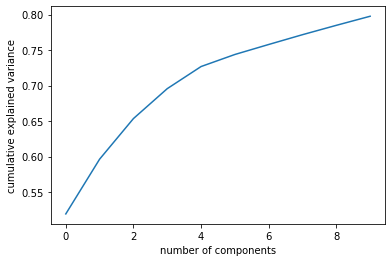

In [40]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');


In [41]:
np.argwhere(np.isnan(artist_region_pca.components_))

array([], shape=(0, 2), dtype=int64)

In [42]:
artist_region.index

MultiIndex([('#90s Update', 'GB-BRY'),
            ('#90s Update', 'GB-COV'),
            ('#90s Update', 'GB-GLG'),
            ('#90s Update', 'GB-HAV'),
            ('#90s Update', 'GB-HLD'),
            ('#90s Update', 'GB-LND'),
            ('#90s Update', 'GB-NFK'),
            ('#90s Update', 'GB-NTH'),
            ('#90s Update', 'GB-NWP'),
            ('#90s Update', 'GB-WAR'),
            ...
            (       'flor', 'GB-WIL'),
            (       'flor', 'GB-WLL'),
            (       'flor', 'GB-WLV'),
            (       'flor', 'GB-WOK'),
            (       'flor', 'GB-WSX'),
            (  'livetune+', 'GB-ABE'),
            (  'livetune+', 'GB-BIR'),
            (  'livetune+', 'GB-HAM'),
            (  'livetune+', 'GB-NGM'),
            (  'livetune+', 'GB-SWK')],
           names=['artist_name', 'region_code'], length=34867)

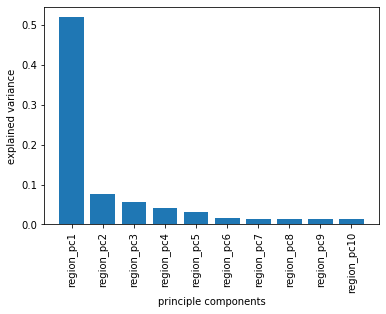

In [43]:
'''
generate a name list for the principle components and create a Dataframe for the region_pca and use the name list created above. Get the artist name in
the region_stream_unstack dataframe and Concatenate artist_pca and region_pca dataframe along the columns.
'''
pc_name=[]
for i in range(1,11):
    pc_name.append('region_pc'+str(i))

region_pcaDF = pd.DataFrame(data=np.transpose(artist_region_pca.components_), columns=pc_name)
artist_pca = pd.Series(feature_region.index.values, name='artist_name')

region_pcaDF = pd.concat([artist_pca, region_pcaDF],axis=1)

# At last, we can plot the cumunative pca explained variance ratio according to number of components.
plt.bar(pc_name,pca.explained_variance_ratio_)
plt.xticks(rotation=90)
plt.xlabel('principle components')
plt.ylabel('explained variance')
plt.show()

**Data transformation**

The final step is to decide whether or not to normalize/transform any of the features. 

We should normalize data if we are more interested in the relative rather than absolute differences between variables. Given that all the numerical features in our dataset (centrality, lift, influence, gender breakdown, age breakdown) were meaningful, i.e. distances did make a difference;

<div class="alert alert-warning">
<b>ACTION: Feature transformation </b> 

<p> Comment on whether transforming particular features (influence, gender breakdown, age breakdown) is useful. Calculate the transformation where necessary.</p>

</div>


Now we can combine all of our features that we generated above, into a dataframe that can be processed by a machine learning algorithm:

In [44]:
region_pcaDF

,artist_name,region_pc1,region_pc2,region_pc3,region_pc4,region_pc5,region_pc6,region_pc7,region_pc8,region_pc9,region_pc10
0,#90s Update,0.032112,-0.030257,0.156185,0.022361,-0.058256,-0.012337,-0.023166,-0.022176,-0.048415,-0.024148
1,17 Memphis,0.016409,-0.012010,0.090104,-0.103821,-0.035898,-0.005463,-0.015617,-0.021360,-0.033990,0.001537
2,2D,0.046621,-0.094315,0.022649,0.022054,-0.004960,0.062666,-0.021092,0.056782,0.019279,-0.031462
3,3JS,0.036821,-0.098458,-0.105059,-0.014649,-0.039371,-0.050615,-0.003593,-0.008073,-0.014059,0.004878
4,99 Percent,0.039416,-0.086757,-0.037537,-0.056338,-0.038981,0.009413,0.014615,0.003546,0.045349,0.110297
...,...,...,...,...,...,...,...,...,...,...,...
601,Zion,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
602,birthday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
603,dvsn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
604,flor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
# variables 
final_df = pd.merge(df_artist, region_pcaDF, on="artist_name",how="outer")
final_df.head()

,artist_name,stream_count,num_users,passion_score,weight_score,male_per,Youth,Adult,Senior,success,region_pc1,region_pc2,region_pc3,region_pc4,region_pc5,region_pc6,region_pc7,region_pc8,region_pc9,region_pc10
0,#90s Update,16,15,1.066667,1.120404,0.600000,0.200000,0.733333,0.000000,False,0.032112,-0.030257,0.156185,0.022361,-0.058256,-0.012337,-0.023166,-0.022176,-0.048415,-0.024148
1,17 Memphis,12,12,1.000000,1.062500,0.333333,0.416667,0.333333,0.083333,False,0.016409,-0.012010,0.090104,-0.103821,-0.035898,-0.005463,-0.015617,-0.021360,-0.033990,0.001537
2,2D,1,1,1.000000,NaN,1.000000,0.000000,0.000000,0.000000,False,0.046621,-0.094315,0.022649,0.022054,-0.004960,0.062666,-0.021092,0.056782,0.019279,-0.031462
3,3JS,5,4,1.250000,NaN,0.750000,0.250000,0.750000,0.000000,False,0.036821,-0.098458,-0.105059,-0.014649,-0.039371,-0.050615,-0.003593,-0.008073,-0.014059,0.004878
4,99 Percent,1291,1189,1.085786,1.162259,0.322960,0.346870,0.244501,0.029611,False,0.039416,-0.086757,-0.037537,-0.056338,-0.038981,0.009413,0.014615,0.003546,0.045349,0.110297


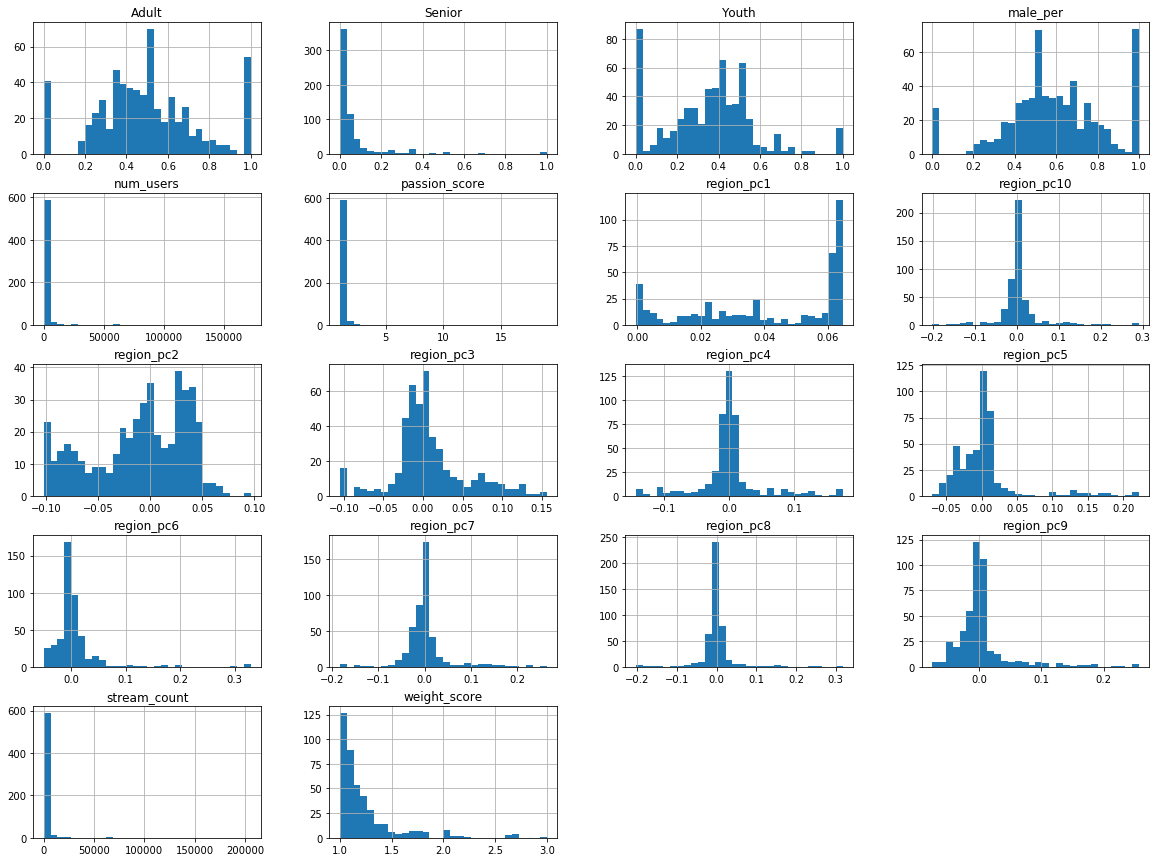

In [46]:
final_df.drop('success', axis=1).hist(bins=30, figsize=(20,15)) #　success is logical bool value, unavailable for hist
plt.show()

In [47]:
#final_df = pd.DataFrame(variables)


<div class="alert alert-warning">
<b>ACTION: Feature transformation </b> 

<p> Comment on whether transforming particular features (influence, gender breakdown, age breakdown) is useful. Calculate the transformation where necessary.</p>

</div>

**Preprocessing**

Before we can run any models on our dataset, we must make sure it is prepared and cleaned to avoid errors in results. This stage is generally refered to as preprocessing.

To begin with, we need to deal with missing data in the dataframe - the ML algorithm will not be able to process NaN or missing values. 

For this study, we will be imputing missing numerical values, and filling any one which we were not able to imput, with 0.

<div class="alert alert-warning">
<b>ACTION: Missing values </b> 

<p> Use the <b>Imputer</b> class to alter your final Dataframe that contains your feature vector.</p>

</div>

In [48]:
array_to_imp = final_df[final_df.columns[final_df.isna().any()].tolist()]
array_to_imp.to_numpy()

array([[ 1.12040441,  0.03211198, -0.03025657, ..., -0.02217574,
        -0.04841466, -0.02414805],
       [ 1.0625    ,  0.01640876, -0.01201001, ..., -0.0213603 ,
        -0.03398984,  0.00153704],
       [        nan,  0.04662073, -0.09431489, ...,  0.05678228,
         0.01927881, -0.03146232],
       ...,
       [ 1.0737705 ,         nan,         nan, ...,         nan,
                nan,         nan],
       [ 1.07905058,         nan,         nan, ...,         nan,
                nan,         nan],
       [ 1.        ,         nan,         nan, ...,         nan,
                nan,         nan]])

In [49]:
# Handle missing values
from sklearn.impute import SimpleImputer

imp = SimpleImputer(missing_values=np.nan, strategy='median')

imp.fit(array_to_imp)

impped_array = imp.transform(array_to_imp)

print(impped_array.shape)
impped_list = impped_array.transpose().tolist()
print(len(impped_list))

# fill remaining nan with 0


(617, 11)
11


In [50]:
final_df_drop = final_df.copy()
for i, l in enumerate(impped_list):
    final_df_drop[final_df_drop.columns[final_df.isna().any()][i]] = l
    

Next, we need to make sure that none of the variables going into the model are collinear, and if so, we need to remove those variables that are highly correlated.

<div class="alert alert-warning">
<b>ACTION: Multi-collinearity </b> 

<p> Check and deal with multi-collinearity in your feature set.</p>

</div>

In [51]:
# Check for multicollinearity
# Check for highly correlated variables (>90%)

features=['stream_count', 'num_users', 'passion_score', 'male_per',
       'ave_age', 'region_pc1', 'region_pc2', 'region_pc3',
       'region_pc4', 'region_pc5', 'region_pc6', 'region_pc7', 'region_pc8',
       'region_pc9', 'region_pc10']

c = final_df_drop[features].corr().abs()
print(c)
s = c.unstack()
print('\n ************************************ s  ****************** \n')
print(s)

KeyError: "['ave_age'] not in index"

In [ ]:
corr_sorted = sorted(s.items(),key = lambda x: x[1], reverse=True)
corr_sorted = [corr_sorted[x] for x in range(len(corr_sorted)) if corr_sorted[x][1]!=1]
corr_sorted

In [ ]:
# Remove one of highly correlated varibles (test removing other as well)


Finally, we want to take a look out the class balance in our dependent variable.

Given the natural bias in our data, i.e. there are more cases of failure than of success in the training and test sets; there is a strong bias toward predicting ‘failure’. Based on our complete (unbalanced classes) training sample, if the model only predicted ‘failure’, we would achieve an accuracy of 88.8%. 

To give us a more even class balance, without losing too much data, we will sample data from the bigger class to achive a class balance closer to 60-40. 

There is another way to determine the accuracy of our predictions using a confusion matrix and ROC curve, but more on that later. For now, we will go ahead with sampling the bigger class:

<div class="alert alert-warning">
<b>ACTION: Class balance </b> 

<p> Calculate and comment on class balance.</p>

</div>

In [ ]:
success_count = final_df_drop.success.value_counts()
print('failure :', success_count[0])
print('success :', success_count[1])
print('Proportion:', round(success_count[0] / success_count[1], 2), ': 1')

success_count.plot(kind='bar', title='Count (success)');

In [ ]:
# sampling the bigger class

In [ ]:
# Class count
count_fail, count_suc  = final_df_drop.success.value_counts()

# Divide by class
df_suc = final_df_drop[final_df_drop['success'] == 1]
df_fail = final_df_drop[final_df_drop['success'] == 0]
print(df_suc.shape)
print(df_fail.shape)

In [ ]:
count_fail

In [ ]:
# Random under-sampling

df_fail_under = df_fail.sample(int(count_suc/40*60))  # achive a class balance closer to 60-40.

df_test_under = pd.concat([df_fail_under, df_suc], axis=0)

print('Random under-sampling:')
print(df_test_under.success.value_counts())

df_test_under.success.value_counts().plot(kind='bar', title='Count (success)');


In [ ]:
# Class balance
final_df_drop.groupby('success').groups

***
# <span style="color:orange"> WEEK 5 Assignment</span>
# <span style="color:orange"> Submission Deadline: 20.02.2020</span>
## 4.	Evaluate algorithms 

**Model Selection**

There are number of classification models available to us via the **`scikit-learn`** package, and we can rapidly experiment using each of them to find the optimal model.

Below is an outline of the steps we will take to arrive at the best model:

*	Split data into training and validation (hold-out) set
*	Use cross-validation to fit different models to training set
*	Select model with the highest cross-validation score as model of choice
*	Tune hyper parameters of chosen model.
*	Test the model on hold-out set


<div class="alert alert-warning">
<b>ACTION: Spot-check algorithms </b> 

<p> Try a mixture of algorithm representations (e.g. instances and trees). </p>

<p> Try a mixture of learning algorithms (e.g. different algorithms for learning the same type of representation).<p>

<p> Try a mixture of modeling types (e.g. linear and nonlinear functions or parametric and nonparametric).</p>

<p> Divide this work up among the different members of your team and then compare and comment on the performance of various approaches.</p>

</div>

In [ ]:
# Split into train and validation set
from sklearn.model_selection import train_test_split
features2=['passion_score','malepercentage','weightedscore',
           'Dependent','Senior','YoungAdult',
           'region_pc1', 'region_pc2', 'region_pc3', 
           'region_pc4', 'region_pc5','region_pc6', 
           'region_pc7', 'region_pc8', 'region_pc9', 'region_pc10']

X=final_df[features2]
Y=final_df['success']
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print(len(x_train))

In [ ]:
train_set=x_train.copy()
train_set["success"]=y_train
train_set

In [ ]:
# Class Balance
from sklearn.utils import resample

train_set_fail = train_set[train_set.success==0]
train_set_success = train_set[train_set.success==1]
df_rs = resample(train_set_success, replace=True, n_samples=450, random_state=42)
x_train_final = pd.concat([train_set, df_rs])
x_train_final
x_train_final.success.value_counts()

In [ ]:
# split the x_train_final dataset into dependent variable and independent variables

x_final=x_train_final[features2]
y_final=x_train_final['success']

In [ ]:
# from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVR
from sklearn.neighbors import KNeighborsClassifier

# YOU CAN EXPERIMENT WITH CLASSIFIERS NOT EXPLICITLY COVERED IN CLASS 

# classifiers 
from sklearn.model_selection import cross_val_score
X =x_final.values
y = y_final.values
tree_clf = DecisionTreeClassifier()
FOLDS = 5
s_secision_tree = cross_val_score(tree_clf, X, y, cv=FOLDS, verbose=0)
print("tree_clf: " + str(s_secision_tree.mean()))
#bag_clf = BaggingClassifier()
#FOLDS = 5
#s_secision_tree = cross_val_score(estimator_decision_tree, X, y, cv=FOLDS, verbose=0)
#print("bag_clf: " + str(s_secision_tree.mean()))
SGD_clf=SGDClassifier()
FOLDS = 5
s_SGD = cross_val_score(SGD_clf, X, y, cv=FOLDS, verbose=0)
print("SGD_clf: " + str(s_SGD.mean()))
forest = RandomForestClassifier()
FOLDS = 5
s_forest = cross_val_score(forest, X, y, cv=FOLDS, verbose=0)
print("forest: " + str(s_forest.mean()))
KNN_classifier = KNeighborsClassifier()
FOLDS = 5
s_KNN = cross_val_score(KNN_classifier, X, y, cv=FOLDS, verbose=0)
print("KNN_classifier: " + str(s_KNN.mean()))
svm_reg_clf=LinearSVR()
FOLDS = 5
s_SVR = cross_val_score(svm_reg_clf, X, y, cv=FOLDS, verbose=0)
print("svm_reg_clf: " + str(s_SVR.mean()))


In [ ]:
# def get_feature_names

In [ ]:
#for clf in classifiers:
    #clf.fit(X, y)
    # score = clf.score(X_test, y_test)
   


## 5. Present Results

### Confusion Matrix

To get a better idea of the quality of our predictions, we can plot a confusion matrix and ROC curve. 


A confusion matrix is a technique for summarizing the performance of a classification algorithm that allows visualization of the performance of an algorithm. 

Each row of the matrix represents the instances in a predicted class while each column represents the instances in an actual class (or vice versa). 

The confusion matrix shows the ways in which your classification model is confused when it makes predictions. It gives you insight not only into the errors being made by your classifier but more importantly the types of errors that are being made.

<div class="alert alert-warning">
<b>ACTION:  Confusion matrix  </b> 

<p> Comment on the performance of your final algorithm. Repeat analysis from earlier in the Notebook if necessary. </p>

<p> Explain confusion matrix results, calculate accuracy and precision etc. </p>

</div>

In [ ]:
# Confusion Matrix

In [ ]:
# Plot Confusion Matrix


### ROC Curve 

Receiver Operating Characteristic (ROC) curves show the ability of the model to classify subjects correctly across a range of decision thresholds, i.e. it plots the True Positive Rate vs. False Positive Rate at every probability threshold. 

The AUC summarizes the results of an ROC – it is the probability that a randomly chosen ‘success’ example has a higher probability of being a success than a randomly chosen ‘failure’ example. A random classification would yield an AUC of 0.5, and a perfectly accurate one would yield 1.


<div class="alert alert-warning">
<b>ACTION:  ROC Curve </b> 

<p> Comment on the performance of your final algorithm. Repeat analysis from earlier in the Notebook if necessary. </p>

<p> Explain any observations about the ROC results. </p>

</div>

In [ ]:
# # ROC curve

# Plot classifier ROC


Now that you have a validated model, we can potentially analyze the features of the model, to understand which ones have had the most impact on predicting an artist’s success. 

To do this, we can plot the feature importance as determined by the classifier:

<div class="alert alert-warning">
<b>ACTION:  Feature importance</b> 

<p> Where possible, comment on the feature selection and performance of your final algorithm. Repeat analysis from earlier in the Notebook if necessary. </p>

<p> Explain any observations about the sensitivity of your final analysis. </p>

</div>

In [ ]:
# Feature importance analysis 



## Summary 

**Please provide summaries of the work completed and the outcomes of the analysis**




## Tips completing the coursework 

- **Faculty** - You are free to run the code on your local machine, but if training timings and memory become an issue then use Faculty to complete the coursework. Technical support for using Faculty will be provided as necessary. 


- **JIRA** - Assess the different potential work packages and break the overall objectives into a set of tasks and queue them up in the backlog column of the Kanban board. Create new tasks as and when necessary during the course of your analysis. 


- **Fast First Pass** - Make a first-pass through the project steps as fast as possible. This will give you confidence that you have all the parts that you need and a baseline from which to improve.


- **Attempt Every Step** -  It is easy to skip steps, especially if you are not confident or familiar with the tasks of that step. Try and do something at each step in the process, even if it does not contribute to improved accuracy. You can always build upon it later. Don’t skip steps, just reduce their contribution.


- **Ratchet Accuracy** - The goal of the project is to achieve relatively good model performance (which ever metric you use to measure this) and give you confidence about the ML project structure and workflow. Every step contributes towards this goal. Treat changes that you make as experiments that increase accuracy as the golden path in the process and reorganize other steps around them. Performance is a ratchet that can only move in one direction (better, not worse).


- **Adapt As Needed** - Do not limit your analysis to the instructions provided in Guidelines cells, feel free to expand your analysis beyond them. 